In [37]:
# Qiskit simulator for MBQC gates
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import Aer
from scipy.stats import unitary_group

# u2(0,np.pi/2) = sdg() * h()
# u2(0,np.pi) = h()
def arbitrary_measurement(a):
    uni = np.array([[1,np.exp(1j*a)],[1,-1*np.exp(1j*a)]])/np.sqrt(2)
    return uni

def linear_cluster(size, random_ini = True):
    q= QuantumRegister(size)
    c= ClassicalRegister(size)
    circ= QuantumCircuit(q, c)
    
    #Initializing; apply the generated random unitary if desired
    if random_ini ==True:
        rand_u = unitary_group.rvs(2) #random unitary that rotates the first qubit in the graph
        rand_u_inv = np.conj(rand_u.T) #inverse of the above line
        ru = Operator(rand_u)
        rui = Operator(rand_u_inv)
        circ.unitary(rand_u, q[0], label='rand_u')
        
    for i in range (1,size):
        circ.h(q[i])
    for i in range (size-1):
        circ.cz(q[i],q[i+1])
    if random_ini ==True:
        return circ, rand_u_inv
    else: 
        return circ
    
def linear_cluster_with_ancilla(size, random_ini = True): #with an ancilla to record some extra operations
    q= QuantumRegister(size+1)
    c= ClassicalRegister(size+1)
    circ= QuantumCircuit(q, c)
    
    #Initializing; apply the generated random unitary if desired
    if random_ini ==True:
        rand_u = unitary_group.rvs(2) #random unitary that rotates the first qubit in the graph
        rand_u_inv = np.conj(rand_u.T) #inverse of the above line
        ru = Operator(rand_u)
        rui = Operator(rand_u_inv)
        circ.unitary(rand_u, q[0], label='rand_u')
        
    for i in range (1,size):
        circ.h(q[i])
    for i in range (size-1):
        circ.cz(q[i],q[i+1])
    if random_ini ==True:
        return circ, rand_u_inv
    else: 
        return circ    
    
def benchmarking_RZ(theta,shots,p = 0): # the benchmarking circuit for a single random input state vector instance
    noise_model = get_noise(p)
    circ, rand_u_inv= linear_cluster(5,random_ini = True)
    q, c = circ.qubits, circ.clbits

    #Teleportation Measurements
    circ.u2(0,np.pi,q[0])#rotating into x-basis
    circ.measure(q[0],c[0])
    circ.u2(0,np.pi,q[1])#rotating into x-basis
    circ.measure(q[1],c[1])
    #adaptively choose measurement base for the third qubit
    circ.unitary(Operator(arbitrary_measurement(-1*theta)),q[2],label='unitary').c_if(c[1], 1)
    circ.unitary(Operator(arbitrary_measurement(theta)),q[2],label='unitary').c_if(c[1], 0)
    circ.measure(q[2],c[2])
    circ.u2(0,np.pi,q[3])#rotating into x-basis
    circ.measure(q[3],c[3])
    for i in [1,3]:
        circ.x(q[-1]).c_if(c[i], 1)
    for i in [0,2]:
        circ.z(q[-1]).c_if(c[i], 1)
    
    circ.rz(-1*theta,q[-1])
    circ.unitary(rand_u_inv, q[-1], label='rand_u_inv')
    circ.measure(q[-1],c[-1])
    # Run the quantum circuit on a simulator backend
    simulator = Aer.get_backend('aer_simulator')
    # Create a Quantum Program for execution
    job = simulator.run(circ)

    result = simulator.run(circ,noise_model=noise_model,shots= shots).result()
    counts = result.get_counts(circ)
    return count_to_fid(counts)


def benchmarking_H(shots,p = 0): # the benchmarking circuit for a single random input state vector instance
    noise_model = get_noise(p)
    circ, rand_u_inv= linear_cluster(5,random_ini = True)
    q, c = circ.qubits, circ.clbits
    
    #Teleportation Measurements
    circ.u2(0,np.pi,q[0])#rotating into x-basis
    for qubit in range (1,4):
        circ.u2(0,np.pi/2,q[qubit])#rotating into y-basis
    circ.measure(q[:-1],c[:-1])
    for i in [1,2]:
        circ.z(q[-1]).c_if(c[i], 1)
    for i in [0,2,3]:
        circ.x(q[-1]).c_if(c[i], 1)
    
    circ.h(q[-1])
    circ.unitary(rand_u_inv, q[-1], label='rand_u_inv')
    circ.measure(q[-1],c[-1])
    # Run the quantum circuit on a simulator backend
    simulator = Aer.get_backend('aer_simulator')
    # Create a Quantum Program for execution
    job = simulator.run(circ)

    result = simulator.run(circ,noise_model=noise_model,shots= shots).result()
    counts = result.get_counts(circ)
    return count_to_fid(counts)

def benchmarking_S(shots,p = 0): # the benchmarking circuit for a single random input state vector instance
    #noise_model = get_noise(p)
    circ, rand_u_inv = linear_cluster(5,random_ini = True)
    q, c = circ.qubits, circ.clbits
    
    #Teleportation Measurements
    for qubit in [0,1,3]:
        circ.u2(0,np.pi,q[qubit])#rotating into x-basis
    circ.u2(0,np.pi/2,q[2])
    circ.measure(q[:-1],c[:-1])
    
    #correction rules
    for i in [0,1,2]:
        circ.z(q[-1]).c_if(c[i], 1)
    for i in [1,3]:
        circ.x(q[-1]).c_if(c[i], 1)
    circ.z(q[-1])
    
    circ.sdg(q[-1])
    circ.unitary(rand_u_inv, q[-1], label='rand_u_inv')
    circ.measure(q[-1],c[-1])
    # Run the quantum circuit on a simulator backend
    simulator = Aer.get_backend('aer_simulator')
    # Create a Quantum Program for execution
    job = simulator.run(circ)

    result = simulator.run(circ,noise_model=get_noise(p),shots= shots).result()
    counts = result.get_counts(circ)
    return count_to_fid(counts)

def benchmarking_I(shots,p = 0): # the benchmarking circuit for a single random input state vector instance
    noise_model = get_noise(p)
    circ, rand_u_inv = linear_cluster(3,random_ini = True)
    q, c = circ.qubits, circ.clbits
      
        
    circ.u2(0,np.pi,q[0])
    circ.u2(0,np.pi,q[1])
    circ.measure(q[:-1],c[:-1])
    
    circ.z(q[-1]).c_if(c[0], 1)
    circ.x(q[-1]).c_if(c[1], 1)
    
    circ.unitary(rand_u_inv, q[-1], label='rand_u_inv')
    circ.measure(q[-1],c[-1])

    # Run the quantum circuit on a simulator backend
    simulator = Aer.get_backend('aer_simulator')
    # Create a Quantum Program for execution
    job = simulator.run(circ)

    result = simulator.run(circ,noise_model=noise_model,shots= shots).result()
    counts = result.get_counts(circ)

    return count_to_fid(counts)

def benchmarking_Rotation(angles,shots,p = 0): # the benchmarking circuit for a single random input state vector instance
    [t1,t2,t3] = angles
    noise_model = get_noise(p)
    circ, rand_u_inv= linear_cluster_with_ancilla(5,random_ini = True)
    q, c = circ.qubits, circ.clbits
    #a clever trick that combines classical measurement results
    
    #Teleportation Measurements
    circ.u2(0,np.pi,q[0])#rotating into x-basis
    circ.measure(q[0],c[0])
    
    #adaptively choose measurement base for the second qubit
    circ.unitary(Operator(arbitrary_measurement(-1*t1)),q[1],label='unitary').c_if(c[0], 1)
    circ.unitary(Operator(arbitrary_measurement(t1)),q[1],label='unitary').c_if(c[0], 0)
    #circ.u2(0,np.pi,q[1])
    circ.measure(q[1],c[1])
    
    #adaptively choose measurement base for the third qubit
    circ.unitary(Operator(arbitrary_measurement(-1*t2)),q[2],label='unitary').c_if(c[1], 1)
    circ.unitary(Operator(arbitrary_measurement(t2)),q[2],label='unitary').c_if(c[1], 0)
    #circ.u2(0,np.pi,q[2])
    circ.measure(q[2],c[2])
    
    
    circ.x(q[-1]).c_if(c[0], 1)
    circ.x(q[-1]).c_if(c[2], 1)
    circ.measure(q[-1],c[-1])
    #adaptively choose measurement base for the fourth qubit
    circ.unitary(Operator(arbitrary_measurement(-1*t3)),q[3],label='unitary').c_if(c[-1], 1)
    circ.unitary(Operator(arbitrary_measurement(t3)),q[3],label='unitary').c_if(c[-1], 0)
    #circ.u2(0,np.pi,q[3])
    circ.measure(q[3],c[3])
    
    for i in [1,3]:
        circ.x(q[4]).c_if(c[i], 1)
    for i in [0,2]:
        circ.z(q[4]).c_if(c[i], 1)
    
    #circ.u3(-1*t1,-1*t3,-1*t2,q[-1])
    circ.rx(-1*t3,q[4])
    circ.rz(-1*t2,q[4])
    circ.rx(-1*t1,q[4])
    circ.unitary(rand_u_inv, q[4], label='rand_u_inv')
    circ.measure(q[4],c[4])
    
    # Run the quantum circuit on a simulator backend
    simulator = Aer.get_backend('aer_simulator')
    # Create a Quantum Program for execution
    job = simulator.run(circ)
    
    result = simulator.run(circ,noise_model=noise_model,shots= shots).result()
    counts = result.get_counts(circ)
    old_keys = list(counts.keys())
    #get rid of the ancilla registers...
    for i in range (len(list(counts.keys()))):    
        counts[old_keys[i][1:]] = counts.pop(old_keys[i])
    count_to_fid(counts)    
    return count_to_fid(counts)

# post processing the data: from output data to infidelity 
# the last qubit should be 0 if a teleportation gate is successful
def count_to_fid(counts):
    ct_valid = 0
    ct_total = 0
    for key in counts.keys():
        if key[0] == '0':
            ct_valid += counts[key]
        ct_total += counts[key]
    return ct_valid/ct_total

#erorr model - measurement error only
def get_noise(p):
    p2 = p/15 
    p1 = p
    error_meas = pauli_error([('X',p1/3),('Z',p1/3),('Y',p1/3), ('I', 1 - p1)]) #isotropic error model
    error_cz = pauli_error([('IX',p2),('IZ',p2),('IY',p2),('XI',p2),('ZI',p2),('YI',p2), ('XX',p2),('XY',p2),('XZ',p2),('YX',p2),('YY',p2),('YZ',p2),('ZX',p2),('ZY',p2),('ZZ',p2),('II', 1 - p)]) #isotropic error model

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas,'unitary') # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_meas,'u2')
    noise_model.add_all_qubit_quantum_error(error_cz,'cz') 

    return noise_model

def error_rules(p_cz, p_m, error_type, theta = 0):
    #analytically calculated fidelity rules
    p_flip = 2*(p_m)/3+12*p_cz/15
    if error_type == 'H' or error_type == 'S':
        p00 = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
        p01 = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
        p10 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
        p11 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
        F_avg = 0.5 + (3*p00-p01-p10-p11)/6 
        
    elif error_type == 'I':
        p00 = (1-p_flip)**2
        p01 = (1-p_flip)*p_flip
        p10 = (1-p_flip)*p_flip
        p11 = p_flip**2
        F_avg = 0.5 + (3*p00-p01-p10-p11)/6 
        
    elif error_type == 'RZ':
        p00 = (1-p_flip)**4  + p_flip**2 * (1-p_flip)**2 
        q00 = p_flip**4 + p_flip**2 * (1-p_flip)**2 
        p01 = 2*p_flip * (1-p_flip)**3 
        q01 = 2*p_flip**3 * (1-p_flip)
        p10 = 2*p_flip * (1-p_flip)**3 + 2*p_flip**3 * (1-p_flip)
        p11 = 4* p_flip**2 * (1-p_flip)**2 
        F_avg = 0.5 + (3*p00 + (1+2*np.cos(2*theta))*q00-p01-p10-p11 + (1-2*np.cos(2*theta))*q01)/6 

    return F_avg
        

In [42]:
#plist = [0.000001, 0.00001,0.0001,0.001,0.01,0.1]
plist = np.arange(1,10,1)*0.02
fids = []
var = []
for p in plist:
    fid = []
    for k in range (500):
        fid.append(benchmarking_H(100,p))
    fids.append(np.average(fid))
    var.append(np.var(fid)/np.sqrt(500))
    

/var/folders/6z/0c4lt3293z7fq3ymhvchlgj80000gn/T/ipykernel_5722/149825008.py:102: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  circ.u2(0,np.pi,q[0])#rotating into x-basis
/var/folders/6z/0c4lt3293z7fq3ymhvchlgj80000gn/T/ipykernel_5722/149825008.py:104: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  circ.u2(0,np.pi/2,q[qubit])#rotating into 

In [41]:
1-np.array(fids)

array([0.16558203, 0.2837793 , 0.36087891, 0.41582031, 0.45040625,
       0.47344922, 0.48580273, 0.49178125, 0.49641211])

<ErrorbarContainer object of 3 artists>

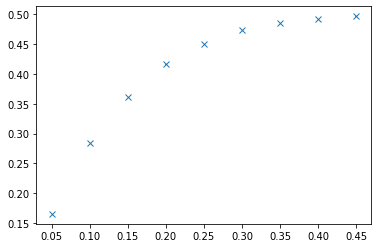

In [39]:
#fid_th3 = []
#for p in plist:
#    fid_th3.append(error_rules(p, 0, 'S', theta = 0))
    
#plt.plot(plist,1-np.array(fid_th3))
plt.errorbar(plist,1-np.array(fids),np.array(var)*np.sqrt(500),marker ='x',linestyle = '')
#

In [19]:
a = 1-np.array(fids)

In [23]:
var

[4.408692098176429e-07,
 1.3095211931060327e-06,
 1.9656644900800114e-06,
 3.1816822092285364e-06,
 3.31725594285427e-06]

In [20]:
a/plist

array([2.12617187, 2.03567708, 2.04507813, 2.01595982, 1.9766059 ])

In [21]:
28/15

1.8666666666666667

In [103]:
fid_th2 = []
for p in plist:
    fid_th2.append(error_rules(p, p, 'H', theta = 0))

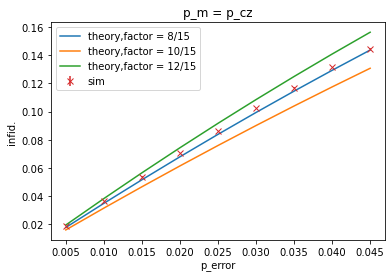

In [111]:
plt.plot(plist,1-np.array(fid_th1))
plt.plot(plist,1-np.array(fid_th2))
plt.plot(plist,1-np.array(fid_th3))

plt.errorbar(plist,1-np.array(fids),np.array(var)*np.sqrt(500),marker ='x',linestyle = '')

plt.xlabel('p_error')
plt.ylabel('infid.')
plt.legend(['theory,factor = 8/15','theory,factor = 10/15','theory,factor = 12/15','sim'])
plt.title('p_m = p_cz')
#plt.loglog()
plt.savefig('test2.pdf')


In [110]:
fid_th1 = [0.9824288395061729,
 0.9652677530864198,
 0.948512,
 0.932156839506173,
 0.9161975308641976,
 0.9006293333333333,
 0.8854475061728395,
 0.8706473086419753,
 0.8562239999999999,]

In [518]:
import time
t = time.time()
fid = []
for k in range (400):
    t1 = 1*np.pi/10
    t2 = 1*np.pi/10
    t3 = 1*np.pi/10
    angles = [t1,t2,t3]
    fid.append(benchmarking_Rotation(angles, 400, p = 0.1))
fids = np.average(fid)
T = time.time()
print(fids,T-t)

/var/folders/6z/0c4lt3293z7fq3ymhvchlgj80000gn/T/ipykernel_36034/690435292.py:171: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  circ.u2(0,np.pi,q[0])#rotating into x-basis


1.0 77.25237107276917


In [64]:
import time
t = time.time()
fids = np.zeros([5,5])
t1 = np.pi/4*1
for i in range (len(fids)):
    for j in range (len(fids[0])):
        fid = []
        for k in range (500):
            t2 = i*np.pi/10
            t3 = j*np.pi/10
            angles = [0,0,0]
            fid.append(benchmarking_Rotation(angles,500,0.15))
        fids[i,j] = np.average(fid)
print(fids,T-t)

/var/folders/6z/0c4lt3293z7fq3ymhvchlgj80000gn/T/ipykernel_2878/3016774277.py:193: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  circ.u2(0,np.pi,q[0])#rotating into x-basis


NameError: name 'T' is not defined

In [ ]:
# data
fids = np.zeros([5,5])
t1 = np.pi/4
for i in range (len(fids)):
    for j in range (len(fids[0])):
        t2 = i*np.pi/10
        t3 = j*np.pi/10
fids = [[0.73995703 0.73601562 0.73825391 0.74411523 0.74121289]
 [0.73492969 0.73761523 0.73383984 0.7365332  0.74125781]
 [0.73776758 0.73483203 0.73873438 0.74153125 0.73810352]
 [0.73323633 0.73416992 0.73883789 0.73840039 0.74311914]
 [0.73494531 0.73838867 0.73646289 0.73943945 0.73964258]]


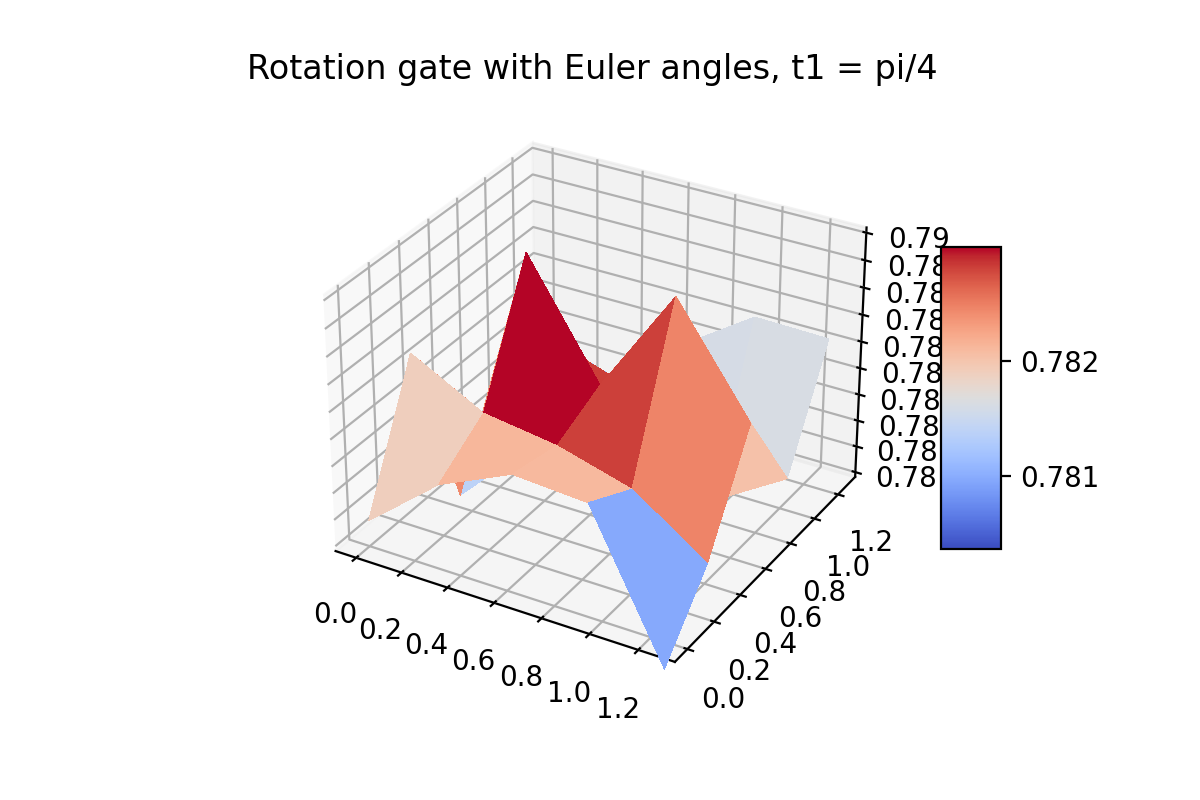

In [118]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
plt.rcParams['text.usetex'] = False
plt.xlabel = ('t1')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.title('Rotation gate with Euler angles, t1 = pi/4')

# Make data.
X = np.arange(0, 5, 1)
Y = np.arange(0, 5, 1)
X, Y = np.meshgrid(X, Y)

Z=np.array(fids)

# Plot the surface.
surf = ax.plot_surface(X*np.pi/10, Y*np.pi/10, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(.78, .785)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.xaxis.set_label('t2')
ax.yaxis.set_label('t3')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('arbitrary_rotation.pdf')
plt.show()



In [130]:
p2 = 1/30
p=1/2
error_cz = pauli_error([('IX',p2),('IZ',p2),('IY',p2),('XI',p2),('ZI',p2),('YI',p2), ('XX',p2),('XY',p2),('XZ',p2),('YX',p2),('YY',p2),('YZ',p2),('ZX',p2),('ZY',p2),('ZZ',p2),('II', 1 - p)]) #isotropic error model
error_cz

QuantumError([(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a16ad60>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a16a910>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a16ae80>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a16a190>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a16a3a0>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a19dca0>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a19dd30>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a19de50>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a19f040>, 0.03333333333333333), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa40a19f0d0>, 0.03333333333333333), (<qiskit.circuit.quantumci

In [393]:
p = np.arange(10)*0.15
fs = []
for i in range (40):
    F_avg = error_rules(p, 'RZ',theta = i*np.pi/40)
    fs.append(F_avg[1])
    print(F_avg)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.     0.7816 0.6416 0.5576 0.5136 0.5    0.5136 0.5576 0.6416 0.7816]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78157374 0.6415409  0.5575409  0.51357374 0.5
 0.5135409  0.55727826 0.64065446 0.77947255]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78149559 0.64136507 0.55736507 0.51349559 0.5
 0.51336507 0.55632094 0.63784114 0.77314257]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78136748 0.64107683 0.55707683 0.51336748 0.5
 0.51307683 0.55475164 0.6332293  0.76276593]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78119257 0.64068328 0.55668328 0.51319257 0.5
 0.51268328 0.55260898 0.62693251 0.74859814]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78097516 0.64019411 0.55619411 0.51297516 0.5
 0.51219411 0.54994572 0.6191058  0.73098805]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78072061 0.63962137 0.55562137 0.51272061 0.5
 0.51162137 0.54682745 0.60994191 0.71036929]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.78043518 0.63897915 0.

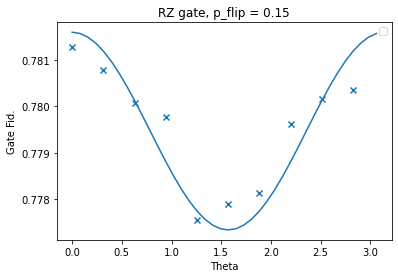

In [394]:
plt.xlabel('Theta')
plt.ylabel('Gate Fid.')

plt.title('RZ gate, p_flip = 0.15')
plt.legend(['theory','simulation',])

plt.plot(np.arange(40)*0.1/4*np.pi,fs)
plt.scatter(np.arange(10)*0.1*np.pi,fids,marker = 'x')
plt.savefig('RZ_gate_015.pdf')

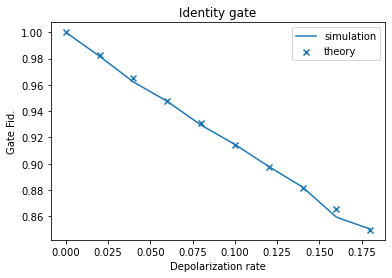

In [76]:

plt.plot(p,fids)
plt.scatter(p,F_avg,marker = 'x')
plt.xlabel('Depolarization rate')
plt.ylabel('Gate Fid.')

plt.title('Identity gate')
plt.legend(['simulation','theory',])
plt.savefig('I_gate.pdf')

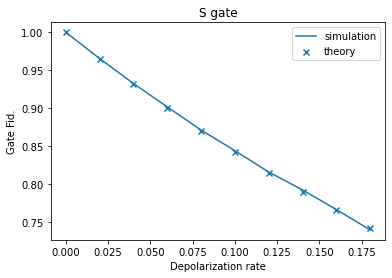

In [87]:
plt.plot(p,fids)
plt.scatter(p,F_avg,marker = 'x')
plt.xlabel('Depolarization rate')
plt.ylabel('Gate Fid.')

plt.title('S gate')
plt.legend(['simulation','theory',])
plt.savefig('S_gate.pdf')

In [167]:
plt.plot(p,[1.0,
 0.964794921875,
 0.9305078125,
 0.8995703125,
 0.872060546875,
 0.84427734375,
 0.813466796875,
 0.790654296875,
 0.7663671875,
 0.742529296875])
plt.scatter(p,qk,marker = 'x')
plt.xlabel('Depolarization rate')
plt.ylabel('Gate Fid.')

plt.title('Hadamard gate')
plt.legend(['simulation','theory',])
plt.savefig('H_gate.pdf')

NameError: name 'p' is not defined

In [208]:
a = 1
uni = np.array([[1,np.exp(1j*a)],[1,-1*np.exp(1j*a)]])/np.sqrt(2)
uni.T

array([[ 0.70710678+0.j        ,  0.38205142+0.59500984j],
       [ 0.70710678+0.j        , -0.38205142-0.59500984j]])

In [156]:

# Make a noisy measure instruction
from qiskit.extensions import IGate

backend = Aer.get_backend('unitary_simulator')
t1,t2,t3 = 1,1,1
#The circuit without measurement
circ = QuantumCircuit(2)
circ.u3(t1,t3,t2,0)
circ.rx(-1*t3,0)
circ.rz(-1*t2,0)
circ.rx(-1*t1,0)
circ.unitary(Operator(arbitrary_measurement(-1*t1)),0,label='unitary')
#circ.rz(0,0)
#circ.x(0)
#circ.u3(0,theta,0,0)
#circ.rz(-1*theta,0)

#job execution and getting the result as an object
job = qiskit.execute(circ, backend)
result = job.result()

#get the unitary matrix from the result object
print(result.get_unitary(circ, decimals=3))

Operator([[ 0.63 +0.518j,  0.043-0.577j,  0.   +0.j   ,  0.   +0.j   ],
          [-0.463+0.348j, -0.776-0.25j , -0.   +0.j   , -0.   +0.j   ],
          [ 0.   +0.j   ,  0.   +0.j   ,  0.63 +0.518j,  0.043-0.577j],
          [-0.   +0.j   , -0.   +0.j   , -0.463+0.348j, -0.776-0.25j ]],
         input_dims=(2, 2), output_dims=(2, 2))


/var/folders/6z/0c4lt3293z7fq3ymhvchlgj80000gn/T/ipykernel_2878/2559996590.py:8: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(t1,t3,t2,0)


In [157]:


for gate in circ.data:
    print('\ngate name:', gate[0].name)
    print('qubit(s) acted on:', gate[1][0])
    print('other paramters (such as angles):', gate[0].params)


gate name: u3
qubit(s) acted on: Qubit(QuantumRegister(2, 'q'), 0)
other paramters (such as angles): [1, 1, 1]

gate name: rx
qubit(s) acted on: Qubit(QuantumRegister(2, 'q'), 0)
other paramters (such as angles): [-1]

gate name: rz
qubit(s) acted on: Qubit(QuantumRegister(2, 'q'), 0)
other paramters (such as angles): [-1]

gate name: rx
qubit(s) acted on: Qubit(QuantumRegister(2, 'q'), 0)
other paramters (such as angles): [-1]

gate name: unitary
qubit(s) acted on: Qubit(QuantumRegister(2, 'q'), 0)
other paramters (such as angles): [array([[ 0.70710678+0.j        ,  0.38205142-0.59500984j],
       [ 0.70710678+0.j        , -0.38205142+0.59500984j]])]


In [142]:
qubits = circ.qubits
qubits.index(qubits[1])

1

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.font_manager
import numpy as np
import matplotlib.pyplot as plt
import pickle
# load style file
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)
import phd_plot_style
pub_fig_style = phd_plot_style.phd_revtex_plots()
# magic commands
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None, 'dpi': 200}
# Colors
cBlues = sns.color_palette("Blues_r", n_colors=7)#[::3]
cOranges = sns.color_palette("Oranges_r", n_colors=7)#[::3]#[1:-1]
cGreens = sns.color_palette("Greens_r", n_colors=7)#[::3]#[1:-1]
cPurples = sns.color_palette("Purples_r", n_colors=7)#[::3]#[1:-1]
cGreys = sns.color_palette("PuRd_r", n_colors=7)#[::3]#[1:-1]
color_zip = [cPurples, cBlues, cOranges, cGreens, cGreys]
# define dimensions
fig_width  = pub_fig_style.revtex_sizes_active["page.columnwidth"] * pub_fig_style.tex_pt_to_inch
fig_height = pub_fig_style._get_revtex_rc()["figure.figsize"][1]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


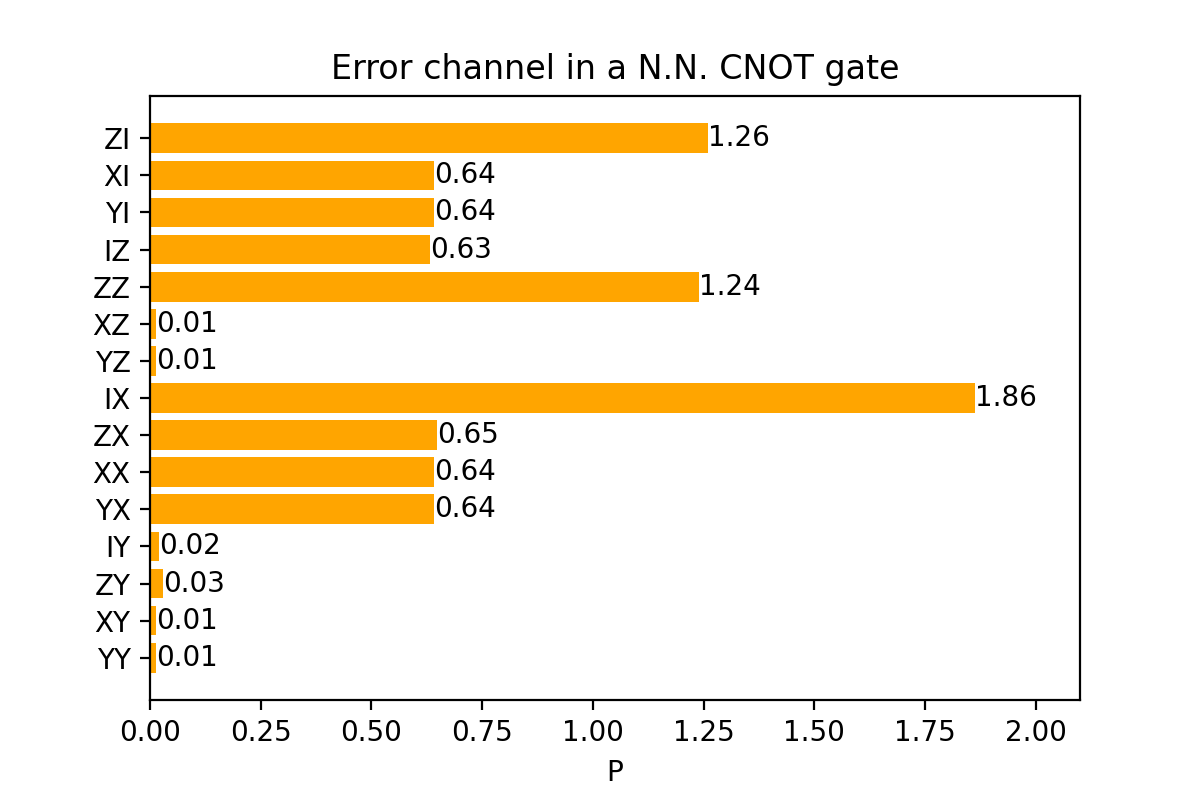

In [183]:
def Hilbertspace_Zr(N,r):
    states=np.zeros((r**N,N),dtype=int)
    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def CNOT_error(p):
    p_flip = p*2/3
    #output a error model for the CNOT gate (in the nearest neighbor setting)
    Nq = 14
    vec = Hilbertspace_Zr(Nq,2)
    err_vec = np.zeros((16,Nq+1),dtype=int)
    for i in range(2**Nq):
        s_flip=vec[i,:]
        sz_c = np.sum(vec[i,[0,2,3,4,7,8,10]])
        sx_c = np.sum(vec[i,[1,2,4,5]])
        sz_t = np.sum(vec[i,[8,10,12]])
        sx_t = np.sum(vec[i,[1,2,7,9,11,13]])
        p_exp = np.sum(vec[i,:])
        
        i_e = np.array([sz_c%2,sx_c%2,sz_t%2,sx_t%2])@ (2**np.arange(4))
        err_vec[i_e,p_exp] += 1
        
    p_vec = p_flip**np.arange(15)*(1-p_flip)**np.arange(14,-1,-1)
    err_prob = err_vec @ p_vec
    pauli_vec = Hilbertspace_Zr(4,2)
    pauli_combined = []
    for i in range(16):
        p_st = ''
        p1 = pauli_vec[i,:2]@ np.array([1,2])
        if  p1 == 0:
            p_st += 'I'
        elif  p1 == 1:
            p_st += 'Z'
        elif  p1 == 2:
            p_st += 'X'
        else:
            p_st += 'Y'
        p2 = pauli_vec[i,2:]@ np.array([1,2])
        if  p2 == 0:
            p_st += 'I'
        elif  p2 == 1:
            p_st += 'Z'
        elif  p2 == 2:
            p_st += 'X'
        else:
            p_st += 'Y'
    
        pauli_combined.append((p_st,err_prob[i]))
    return pauli_combined
error = CNOT_error(.01)
# Fixing random state for reproducibility
np.random.seed(19680801)

# Example data
channel = []
performance = []
for i in range (1,16):
    print(i)
    channel.append(error[i][0])
    performance.append(error[i][1]*100)
y_pos = np.arange(len(error)-1)

fig, ax = plt.subplots()

hbars = ax.barh(y_pos, performance, align='center', color = 'orange')
ax.set_yticks(y_pos, labels=channel)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('P')
ax.set_title('Error channel in a N.N. CNOT gate')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=.021*100)  # adjust xlim to fit labels
plt.savefig('figs/Error_CNOT.pdf')
plt.show()

## A physical MBQC simulator 
Input: a given circuit model

Output: the corresponding MBQC circuit written on a planar graph

Includes the following operations:

 cluster states
 
 single gates:
 H gate, pi/2 phase gate
 general rotation gates
 CNOT
 
 Conversion of a quantum circuit to MBQC;
 Allow snapshots into internal states; 
 Simulate the 'burning process' of cluster states

Also assume that the cluster state can be arbitrary shape, 2D and periodical bdry condition

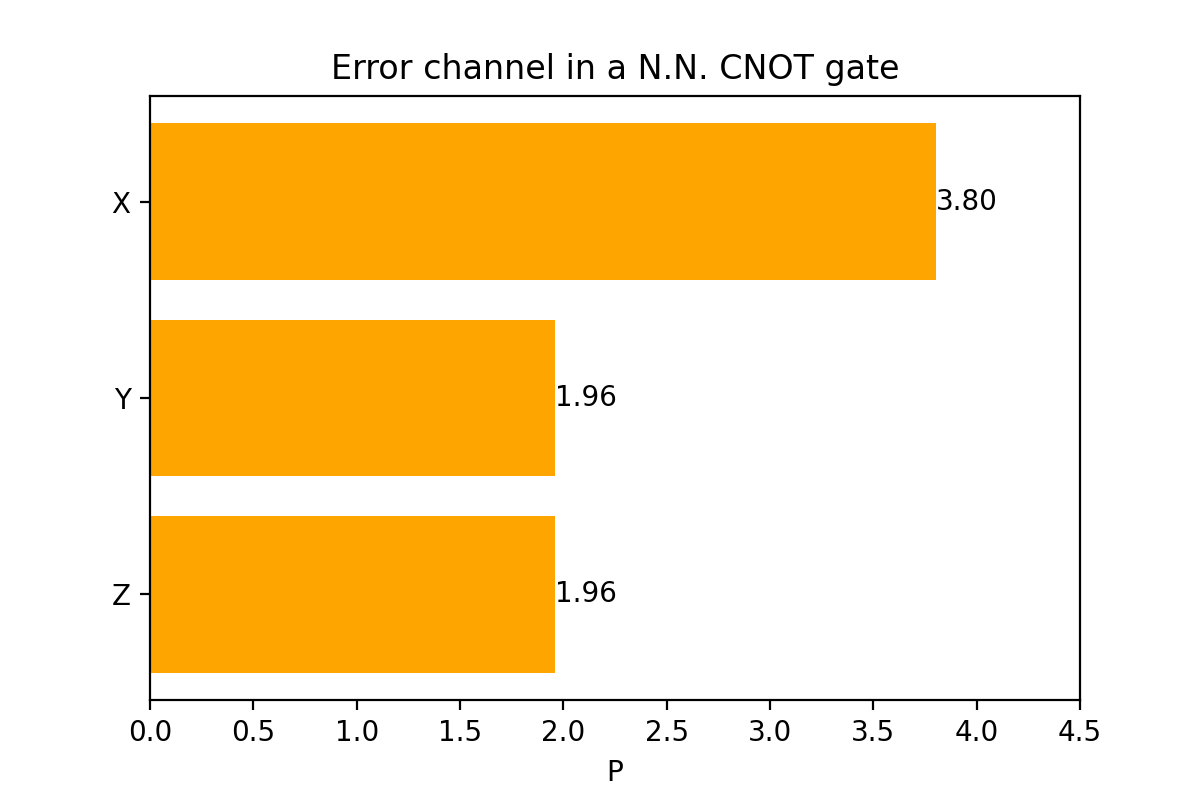

In [180]:
channel = ['X','Y','Z']
performance = [3.8031999999999996, 1.9599999999999996,1.9599999999999996]
y_pos = np.arange(3)

fig, ax = plt.subplots()

hbars = ax.barh(y_pos, performance, align='center', color = 'orange')
ax.set_yticks(y_pos, labels=channel)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('P')
ax.set_title('Error channel in a N.N. CNOT gate')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=.045*100)  # adjust xlim to fit labels
plt.savefig('figs/Error_H_output.pdf')
plt.show()

In [149]:
    for gate in circ.data:
        name = gate[0].name
        print('\ngate name:', gate[0].name)
        print('qubit(s) acted on:', gate[1])
        print('other paramters (such as angles):', gate[0].params)
        


gate name: u3
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [0, 0, 0]

gate name: rz
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [0]


In [ ]:
def MBQC(circ):
    '''
    Inputs -- 
    circ: a circuit model written with Qiskit;
    must contain 3 qubit or less (so that all CNOT gates are N.N.)
    only supports CNOT and following single qubit gates:
    we begin with unitary simulation so no measurement is implemented now
    Output -- 
    mcirc: translated circuit into measurement-based format
    '''
    #setup the stage
    mcirc = QuantumCircuit()
    qubits = circ.qubits
    for i in range(len(qubits)):
        qreg = 
        creg = 
        mcirc.add
    for gate in circ.data:
        name = gate[0].name
        print('\ngate name:', gate[0].name)
        print('qubit(s) acted on:', gate[1])
        print('other paramters (such as angles):', gate[0].params)
        

In [148]:
mcirc = QuantumCircuit()
qubits = circ.qubits # list of all qubits
active_qubit = np.zeros() # which qubit quantum state stores information?

for i in range(2*len(qubits)):
    #setting the stage
    if i%2 ==0:
        qreg = QuantumRegister(2,f'q_comp{i//2}') # need to keep 2 qubits for the simulation
        creg = ClassicalRegister(7,f'cl_comp{i//2}')# classical registers are set to record information
        mcirc.add_register(qreg,creg)
    else: #ancilla registers
        qreg = QuantumRegister(2,f'q_anc{i//2}') 
        creg = ClassicalRegister(7,f'cl_anc{i//2}')
        mcirc.add_register(qreg,creg)
        
for gate in circ.data:
    gate_name = gate[0].name
    qubit_name = gate[1]
    params = gate[0].params
    qubit_index = [qubits.index(qubit) for qubit in qubit_name]
    if gate_name == 'H':
        mcirc = add_H(mcirc,qubit_index)
    elif gate_name == 'S':
        mcirc = add_S(mcirc,qubit_index)
    elif gate_name == 'RZ':
        mcirc = add_RZ(mcirc,qubit_index, params)
    elif gate_name == 'U3_XZX':
        mcirc = add_RZ(mcirc,qubit_index, params)
    elif gate_name == 'CNOT':
        mcirc = add_RZ(mcirc,qubit_index)

def add_H(mcirc,qubit_index,active_qubit):
    indx = active_qubit[qubit_index]
    for i in range(5):
        q = qubit_index[0]
        #establish cluster state here
        mcirc.cz()
        #measurements goes here
        indx = (indx+1)//2
    active_qubit[qubit_index] = indx
    #corrections
    return mcirc, active_qubit

def add_S(mcirc,qubit_index):
    return mcirc

def add_RZ(mcirc,qubit_index, params):
    return mcirc

def add_U3_XZX(mcirc,qubit_index, params): # this is the convetion given in Robert's paper
    return mcirc